# **Project Name** : Integrated Retail Analytics for Store Optimization

##### **Project Type**    - Regression/Classification
##### **Contribution**    - Individual
##### **Nane**            - SREEPRATHAP M

# **Project Summary -**
### This project focuses on analyzing and forecasting weekly sales across multiple stores and departments to enable data-driven decision-making in inventory management, marketing, and store optimization. Using historical sales data combined with external features (holidays, markdowns, regional indicators), the project identifies key sales patterns, seasonal effects, and department correlations. ###

# **GitHub Link -**

#### Importing library

In [1]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestRegressor
try:
    import lightgbm as lgb
    LGB=True
except:
    LGB=False
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split

#### Importing Data

In [2]:
f_ds = pd.read_csv('Features data set.csv') # Features data-set
sa_ds = pd.read_csv('sales data-set.csv') # sales data-set
st_ds = pd.read_csv('stores data-set.csv') # stores data-set

In [3]:
print(f'''Data set informations
_____________________''')
print(f'''
-------------------------------------------
       Features data frame
-------------------------------------------''')
print(f'''{f_ds.info()}''')
print(f'''
-------------------------------------------
       sales data frame
-------------------------------------------''')
print(f'''{sa_ds.info()}''')
print(f'''
--------------------------------------------
       Stores data frame
-------------------------------------------''')
print(f'''{st_ds.info()}''')

Data set informations
_____________________

-------------------------------------------
       Features data frame
-------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8190 entries, 0 to 8189
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         8190 non-null   int64  
 1   Date          8190 non-null   object 
 2   Temperature   8190 non-null   float64
 3   Fuel_Price    8190 non-null   float64
 4   MarkDown1     4032 non-null   float64
 5   MarkDown2     2921 non-null   float64
 6   MarkDown3     3613 non-null   float64
 7   MarkDown4     3464 non-null   float64
 8   MarkDown5     4050 non-null   float64
 9   CPI           7605 non-null   float64
 10  Unemployment  7605 non-null   float64
 11  IsHoliday     8190 non-null   bool   
dtypes: bool(1), float64(9), int64(1), object(1)
memory usage: 712.0+ KB
None

-------------------------------------------
       s

In [4]:
f_ds.isnull().sum()

Store              0
Date               0
Temperature        0
Fuel_Price         0
MarkDown1       4158
MarkDown2       5269
MarkDown3       4577
MarkDown4       4726
MarkDown5       4140
CPI              585
Unemployment     585
IsHoliday          0
dtype: int64


___________________________________
  Table of Null value percentage
___________________________________

         Columns  Null  Percentage
0          Store     0         0.0
1           Date     0         0.0
2    Temperature     0         0.0
3     Fuel_Price     0         0.0
4      MarkDown1  4158        51.0
5      MarkDown2  5269        64.0
6      MarkDown3  4577        56.0
7      MarkDown4  4726        58.0
8      MarkDown5  4140        51.0
9            CPI   585         7.0
10  Unemployment   585         7.0
11     IsHoliday     0         0.0
----------------------------------------------------------------------
"Based on the previous analysis of null values, rows with less than 
10% missing data can be excluded from the DataFrame. These rows are 
listed below."
----------------------------------------------------------------------

         Columns  Null  Percentage
9            CPI   585         7.0
10  Unemployment   585         7.0

------------------------------------

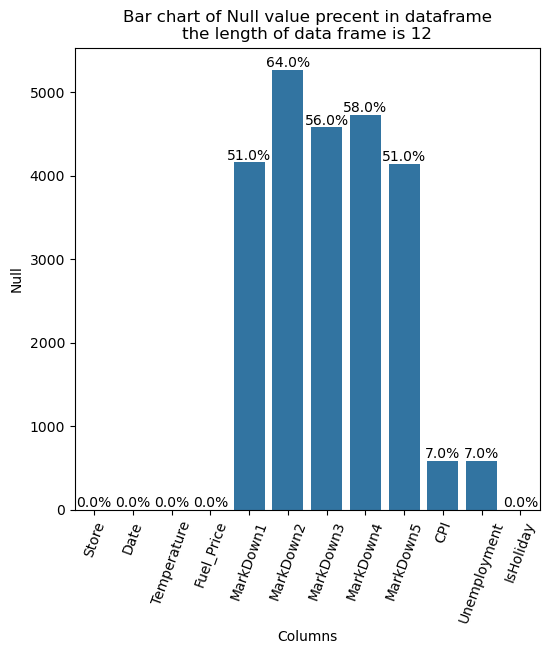

The null vlaue having below 10% are reomved and replaced median with 
null value having above 40%

Store           0
Date            0
Temperature     0
Fuel_Price      0
MarkDown1       0
MarkDown2       0
MarkDown3       0
MarkDown4       0
MarkDown5       0
CPI             0
Unemployment    0
IsHoliday       0
dtype: int64


In [5]:
f_ds1 = f_ds.copy() # copying fetures data for solving null values
f_ds1_null = pd.DataFrame(f_ds1.isnull().sum()).reset_index()
f_ds1_null.columns = ['Columns','Null']
f_ds1_null['Percentage'] = (((f_ds1_null['Null']/len(f_ds1))*100).round(0))
print(f'''
___________________________________
  Table of Null value percentage
___________________________________

{f_ds1_null}
----------------------------------------------------------------------
"Based on the previous analysis of null values, rows with less than 
10% missing data can be excluded from the DataFrame. These rows are 
listed below."
----------------------------------------------------------------------

{f_ds1_null[(f_ds1_null['Null'] >0) & (f_ds1_null['Percentage']<10)]}

----------------------------------------------------------------------
"The columns listed below have more than 40% missing values; dropping 
this amount of rows would significantly reduce the strength of the 
DataFrame. Therefore, it is better to replace the missing values in 
these columns with the median of the respective values."
----------------------------------------------------------------------

{f_ds1_null[(f_ds1_null['Null'] >0) & (f_ds1_null['Percentage']>40)]}''')

plt.figure(figsize=(6,6))
ax=sns.barplot(f_ds1_null, x="Columns", y="Null")
ax.bar_label(ax.containers[0], fontsize=10,labels=f_ds1_null['Percentage'].astype(str)+"%")
plt.xticks(rotation=70)
plt.title(f'''Bar chart of Null value precent in dataframe
the length of data frame is {len(f_ds1_null)}''')
plt.show()


f_ds1.dropna(subset=['CPI','Unemployment'],inplace=True)
cols = ['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']
f_ds1[cols] = f_ds1[cols].fillna(f_ds1[cols].mean())
print(f'''The null vlaue having below 10% are reomved and replaced median with 
null value having above 40%

{f_ds1.isnull().sum()}''')

#### Merging data sets for further analysis 

In [6]:
mer_fds = f_ds1.merge(st_ds, on='Store', how='left')
df = sa_ds.merge(mer_fds, on=["Store", "Date", "IsHoliday"], how="left")

#### Anomaly Detection 

Outlier counts per feature:
Store                0
Dept                 0
Weekly_Sales     35521
Temperature         69
Fuel_Price           0
MarkDown1       150681
MarkDown2       111248
MarkDown3         3197
MarkDown4       134967
MarkDown5       151432
CPI                  0
Unemployment     32114
Size                 0
dtype: int64

Feature with highest outliers: MarkDown5 (151432 outliers)


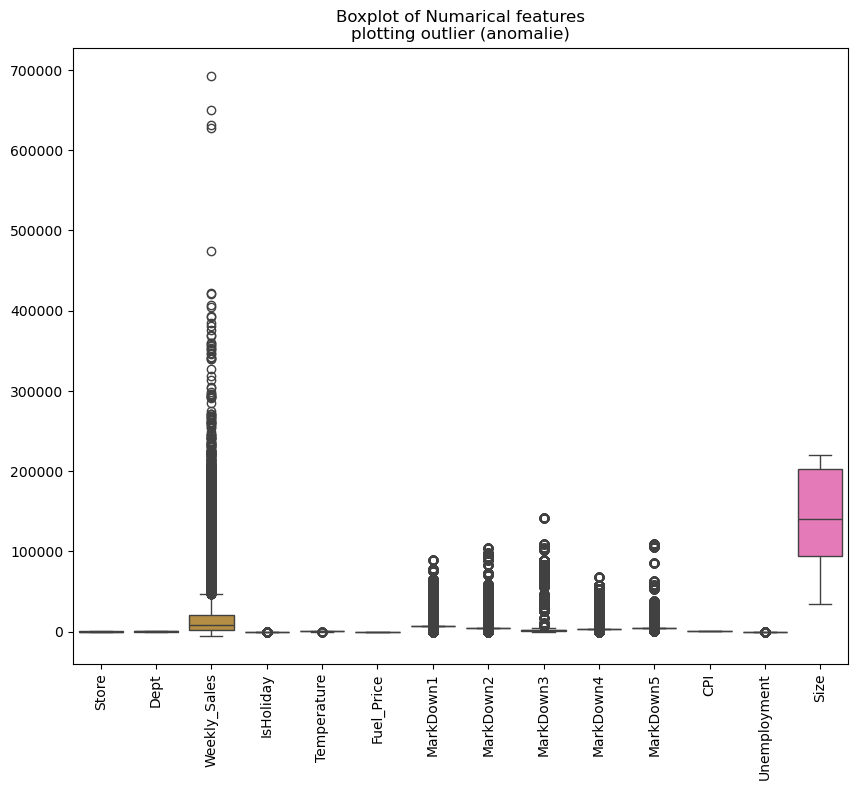

In [7]:
df['Date'] = pd.to_datetime(df['Date'], format="%d/%m/%Y")
numeric_df = df.select_dtypes(include="number")

def count_outliers(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower, upper = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR
    return ((series < lower) | (series > upper)).sum()

outlier_counts = numeric_df.apply(count_outliers)

max_outlier_feature = outlier_counts.idxmax()
max_outlier_count = outlier_counts.max()

print(f'''Outlier counts per feature:
{outlier_counts}''')
print(f"\nFeature with highest outliers: {max_outlier_feature} ({max_outlier_count} outliers)" )

plt.figure(figsize=(10,8))
sns.boxplot(data=df)
plt.title(f'''Boxplot of Numarical features
plotting outlier (anomalie)''')
plt.xticks(rotation = 90)
plt.show()


#### Unusual sales patterns across stores and departments

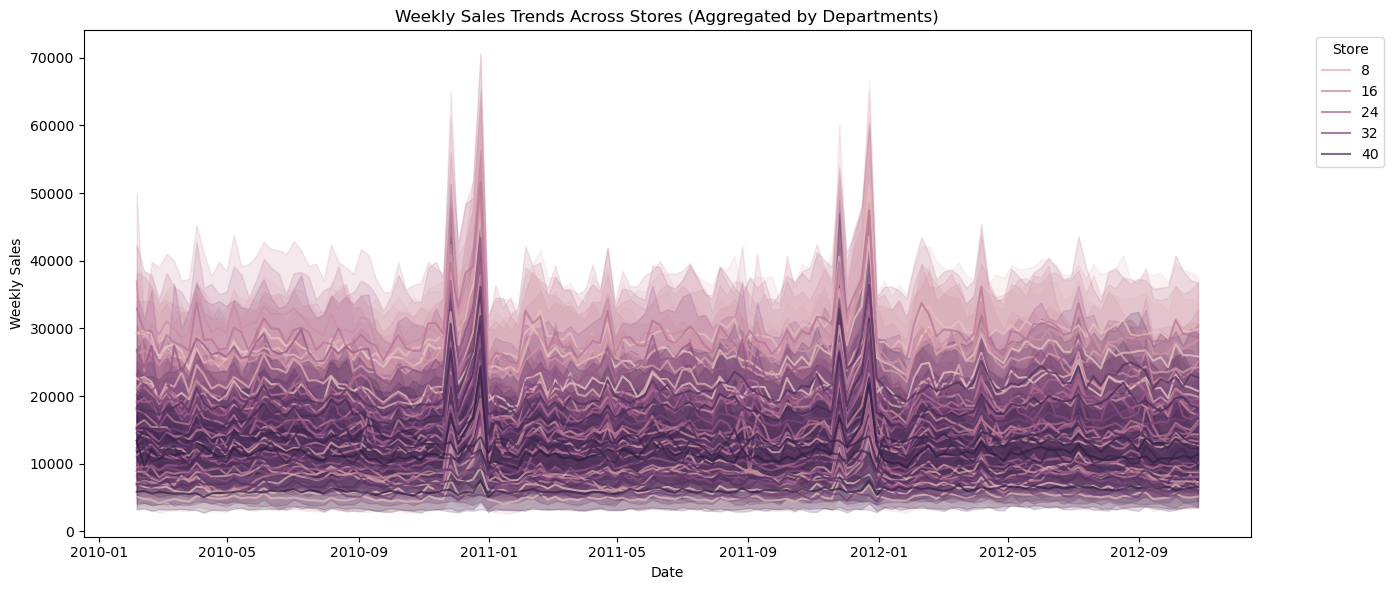

In [8]:

grouped_sales = df.groupby(['Date', 'Store', 'Dept'])['Weekly_Sales'].sum().reset_index()

# Plot line chart for sales trends
plt.figure(figsize=(14, 6))
sns.lineplot(data=grouped_sales, x="Date", y="Weekly_Sales", hue="Store", alpha=0.7)

plt.title("Weekly Sales Trends Across Stores (Aggregated by Departments)")
plt.xlabel("Date")
plt.ylabel("Weekly Sales")
plt.legend(title="Store", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

#### Investigateing potential causes

Correlation of Weekly_Sales with potential causes:

Weekly_Sales    1.000000
Size            0.243828
Dept            0.148032
MarkDown5       0.055658
MarkDown1       0.052131
MarkDown3       0.034818
MarkDown4       0.027121
IsHoliday       0.012774
MarkDown2       0.011614
Fuel_Price     -0.000120
Temperature    -0.002312
CPI            -0.020921
Unemployment   -0.025864
Store          -0.085195
Name: Weekly_Sales, dtype: float64


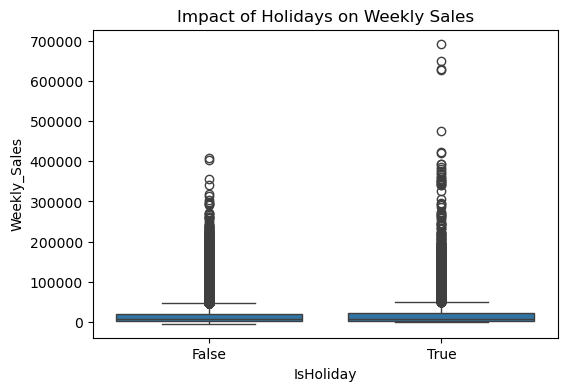

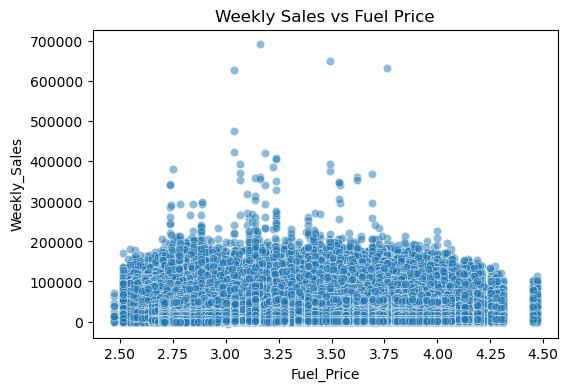

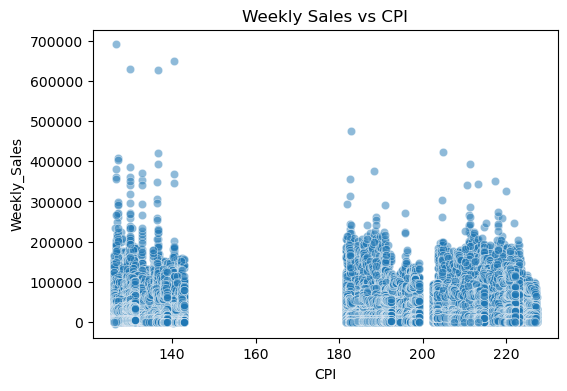

In [9]:
# Correlation analysis (numeric features only)
correlation = df.corr(numeric_only=True)['Weekly_Sales'].sort_values(ascending=False)

print("Correlation of Weekly_Sales with potential causes:\n")
print(correlation)

# Visualization: Sales vs Holidays
plt.figure(figsize=(6,4))
sns.boxplot(data=df, x="IsHoliday", y="Weekly_Sales")
plt.title("Impact of Holidays on Weekly Sales")
plt.show()

# Visualization: Sales vs Fuel Price
plt.figure(figsize=(6,4))
sns.scatterplot(data=df, x="Fuel_Price", y="Weekly_Sales", alpha=0.5)
plt.title("Weekly Sales vs Fuel Price")
plt.show()

# Visualization: Sales vs CPI
plt.figure(figsize=(6,4))
sns.scatterplot(data=df, x="CPI", y="Weekly_Sales", alpha=0.5)
plt.title("Weekly Sales vs CPI")
plt.show()

#### Removing outliers for further analysis

In [10]:
df1=df.copy()
def remove_outliers_all(df):
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    cleaned_df = df.copy()
    
    for col in numeric_cols:
        Q1 = cleaned_df[col].quantile(0.25)
        Q3 = cleaned_df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        cleaned_df = cleaned_df[(cleaned_df[col] >= lower_bound) & (cleaned_df[col] <= upper_bound)]
    
    return cleaned_df

remove_outliers_all(df1)

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
0,1,1,2010-02-05,24924.50,False,42.31,2.572,7346.686886,3918.187853,2026.774066,3349.99341,4257.267299,211.096358,8.106,A,151315
1,1,1,2010-02-12,46039.49,True,38.51,2.548,7346.686886,3918.187853,2026.774066,3349.99341,4257.267299,211.242170,8.106,A,151315
2,1,1,2010-02-19,41595.55,False,39.93,2.514,7346.686886,3918.187853,2026.774066,3349.99341,4257.267299,211.289143,8.106,A,151315
3,1,1,2010-02-26,19403.54,False,46.63,2.561,7346.686886,3918.187853,2026.774066,3349.99341,4257.267299,211.319643,8.106,A,151315
4,1,1,2010-03-05,21827.90,False,46.50,2.625,7346.686886,3918.187853,2026.774066,3349.99341,4257.267299,211.350143,8.106,A,151315
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421514,45,98,2011-10-07,894.98,False,55.82,3.583,7346.686886,3918.187853,2026.774066,3349.99341,4257.267299,187.483796,8.523,B,118221
421515,45,98,2011-10-14,996.40,False,63.82,3.541,7346.686886,3918.187853,2026.774066,3349.99341,4257.267299,187.691748,8.523,B,118221
421516,45,98,2011-10-21,1058.84,False,59.60,3.570,7346.686886,3918.187853,2026.774066,3349.99341,4257.267299,187.784620,8.523,B,118221
421517,45,98,2011-10-28,1167.90,False,51.78,3.569,7346.686886,3918.187853,2026.774066,3349.99341,4257.267299,187.877491,8.523,B,118221


#### Sales trends over time

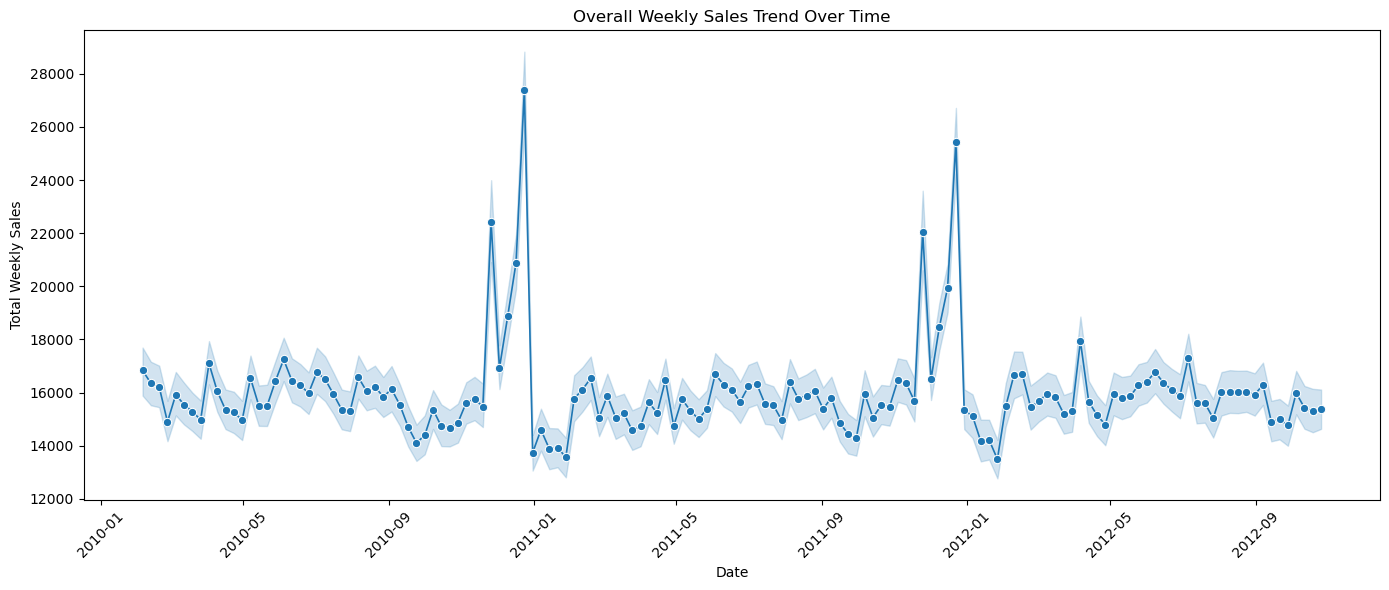

In [11]:
# Aggregate total weekly sales across all stores and departments
sales_trend = df1.groupby("Date")['Weekly_Sales'].sum().reset_index()

# Plot sales trend
plt.figure(figsize=(14,6))
sns.lineplot(data=df1, x="Date", y="Weekly_Sales", marker="o", linewidth=1.2)

plt.title("Overall Weekly Sales Trend Over Time")
plt.xlabel("Date")
plt.ylabel("Total Weekly Sales")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### Seasonal variations and holiday effects on sales

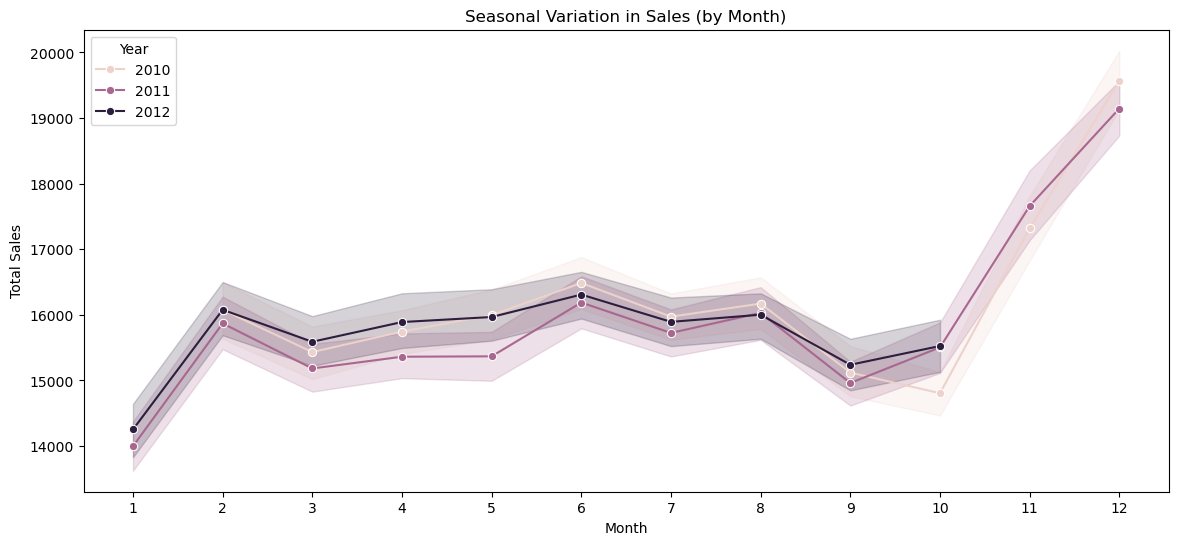

In [12]:
# Extract month and year for seasonal analysis
df2 =df1.copy()
df2['Month'] = df2['Date'].dt.month
df2['Year'] = df2['Date'].dt.year

# Aggregate sales by month
monthly_sales = df2.groupby(['Year', 'Month'])['Weekly_Sales'].sum().reset_index()

# Plot seasonal trend
plt.figure(figsize=(14,6))
sns.lineplot(data=df2, x="Month", y="Weekly_Sales", hue="Year", marker="o")
plt.title("Seasonal Variation in Sales (by Month)")
plt.xlabel("Month")
plt.ylabel("Total Sales")
plt.xticks(range(1,13))
plt.show()

#### Time-series analysis of store & department performance

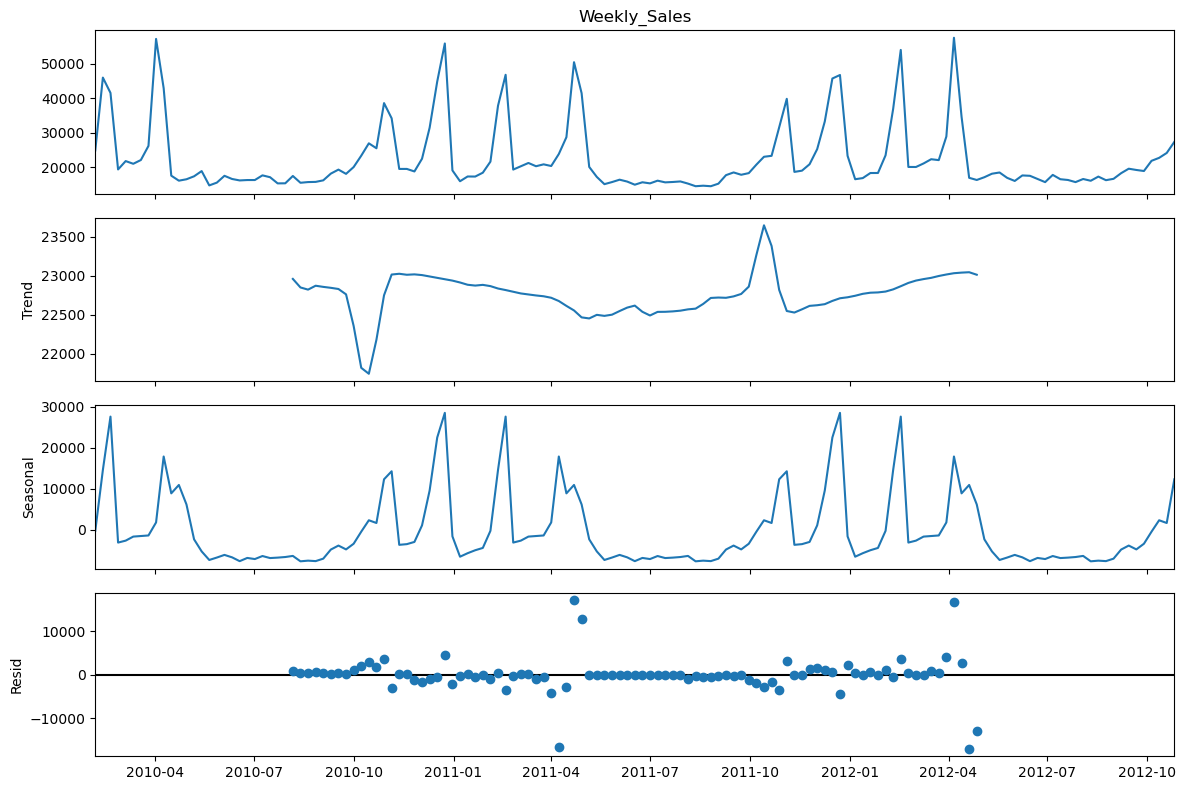

In [13]:
# picking one Store and one Department for detailed time-series analysis
store_id = 1
dept_id = 1

# Filter data
ts_data = df2[(df2['Store'] == store_id) & (df2['Dept'] == dept_id)]

# Aggregate weekly sales (sorted by Date)
ts_data = ts_data.groupby('Date')['Weekly_Sales'].sum().reset_index().sort_values('Date')

# Set Date as index
ts_data = ts_data.set_index('Date')

# Perform seasonal decomposition
decomposition = seasonal_decompose(ts_data['Weekly_Sales'], model='additive', period=52)  # 52 weeks ~ 1 year

# Plot decomposition
plt.rcParams.update({'figure.figsize': (12,8)})
decomposition.plot()
plt.show()

#### Creating new features that could influence sales

In [14]:
df3 = df2.copy()

# --- Time-based features ---
df3['Month'] = df3['Date'].dt.month
df3['Quarter'] = df3['Date'].dt.quarter
df3['Year'] = df3['Date'].dt.year
df3['Week'] = df3['Date'].dt.isocalendar().week
df3['DayOfWeek'] = df3['Date'].dt.dayofweek  # Monday=0, Sunday=6

# --- Regional factors (categorical bins) ---
df3['Temp_Bin'] = pd.cut(df3['Temperature'], bins=[-10, 30, 60, 90, 120], 
                        labels=['Cold', 'Mild', 'Warm', 'Hot'])
df3['Unemployment_Bin'] = pd.cut(df3['Unemployment'], bins=[0, 5, 10, 15], 
                                labels=['Low', 'Medium', 'High'])

# --- Lag features (previous week’s sales & rolling averages) ---
df3 = df3.sort_values(['Store', 'Dept', 'Date'])
df3['Lag_1'] = df3.groupby(['Store', 'Dept'])['Weekly_Sales'].shift(1)
df3['Rolling_4w'] = df3.groupby(['Store', 'Dept'])['Weekly_Sales'].transform(lambda x: x.rolling(window=4).mean())
df3['Rolling_12w'] = df3.groupby(['Store', 'Dept'])['Weekly_Sales'].transform(lambda x: x.rolling(window=12).mean())


##### Dropping null values in new features

In [15]:
df3.dropna(subset=['Lag_1','Rolling_4w','Rolling_12w'],inplace=True)

### Segmenting by group stores departments with similar sales behaviors & gruping using KMeans clustering

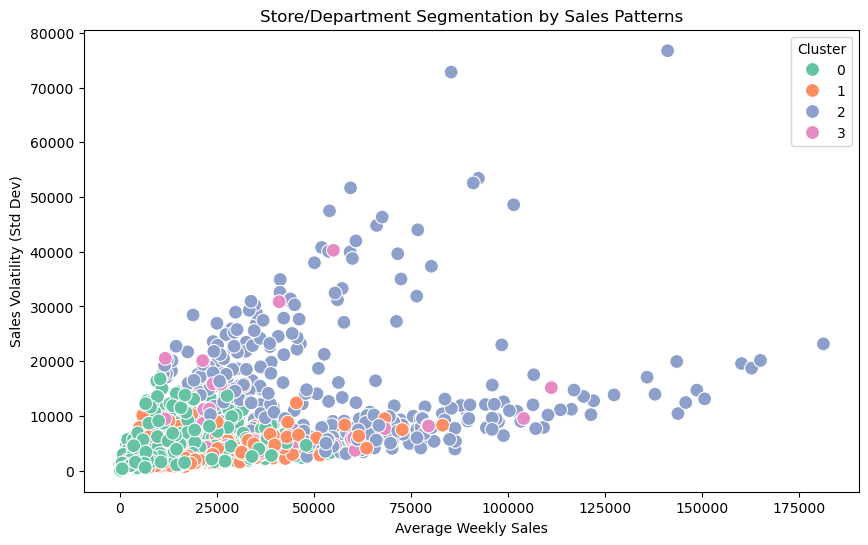

             Store       Dept    Sales_Mean     Sales_Std          MD1  \
Cluster                                                                  
0        22.918647  44.605472  10449.997387   2821.586300  8100.811309   
1        22.437785  44.145675   8092.969127   1785.840556  5986.682160   
2        16.980978  46.105978  55927.853199  14139.143394  8206.111737   
3        38.888889  45.847222  20374.597201   5086.297075  7838.737187   

                 MD2          MD3          MD4           MD5       Temp  \
Cluster                                                                   
0        4015.316869  1915.859942  3653.560527   4508.240278  56.844003   
1        3375.730386  1564.720038  2913.163226   3777.587734  65.801493   
2        4085.055883  1991.617716  3715.880679   4756.448486  61.082493   
3        3660.372503  1908.895973  3394.282013  10059.575415  71.861279   

             Fuel         CPI     Unemp  
Cluster                                  
0        3.492029  1

In [16]:
# Aggregate data by Store & Dept ---
seg_data = df3.groupby(['Store', 'Dept']).agg({
    'Weekly_Sales': ['mean', 'std'],
    'MarkDown1': 'mean',
    'MarkDown2': 'mean',
    'MarkDown3': 'mean',
    'MarkDown4': 'mean',
    'MarkDown5': 'mean',
    'Temperature': 'mean',
    'Fuel_Price': 'mean',
    'CPI': 'mean',
    'Unemployment': 'mean'
}).reset_index()


# Flatten column names
seg_data.columns = ['Store', 'Dept', 'Sales_Mean', 'Sales_Std',
                    'MD1', 'MD2', 'MD3', 'MD4', 'MD5',
                    'Temp', 'Fuel', 'CPI', 'Unemp']

# Handle NaNs ---
# Option A: Fill NaNs with 0 (common for MarkDowns if missing means "no markdown")
seg_data_filled = seg_data.fillna(0)

# Scale features ---
features = seg_data_filled.drop(['Store', 'Dept'], axis=1)
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# KMeans clustering ---
kmeans = KMeans(n_clusters=4, random_state=42)
seg_data_filled['Cluster'] = kmeans.fit_predict(scaled_features)

# Visualization ---
plt.figure(figsize=(10,6))
sns.scatterplot(data=seg_data_filled, x='Sales_Mean', y='Sales_Std', hue='Cluster', palette='Set2', s=100)
plt.title("Store/Department Segmentation by Sales Patterns")
plt.xlabel("Average Weekly Sales")
plt.ylabel("Sales Volatility (Std Dev)")
plt.legend(title="Cluster")
plt.show()

# Inspect cluster profiles ---
cluster_profiles = seg_data_filled.groupby('Cluster').mean()
print(cluster_profiles)

#### Potential product associations within departments using sales data

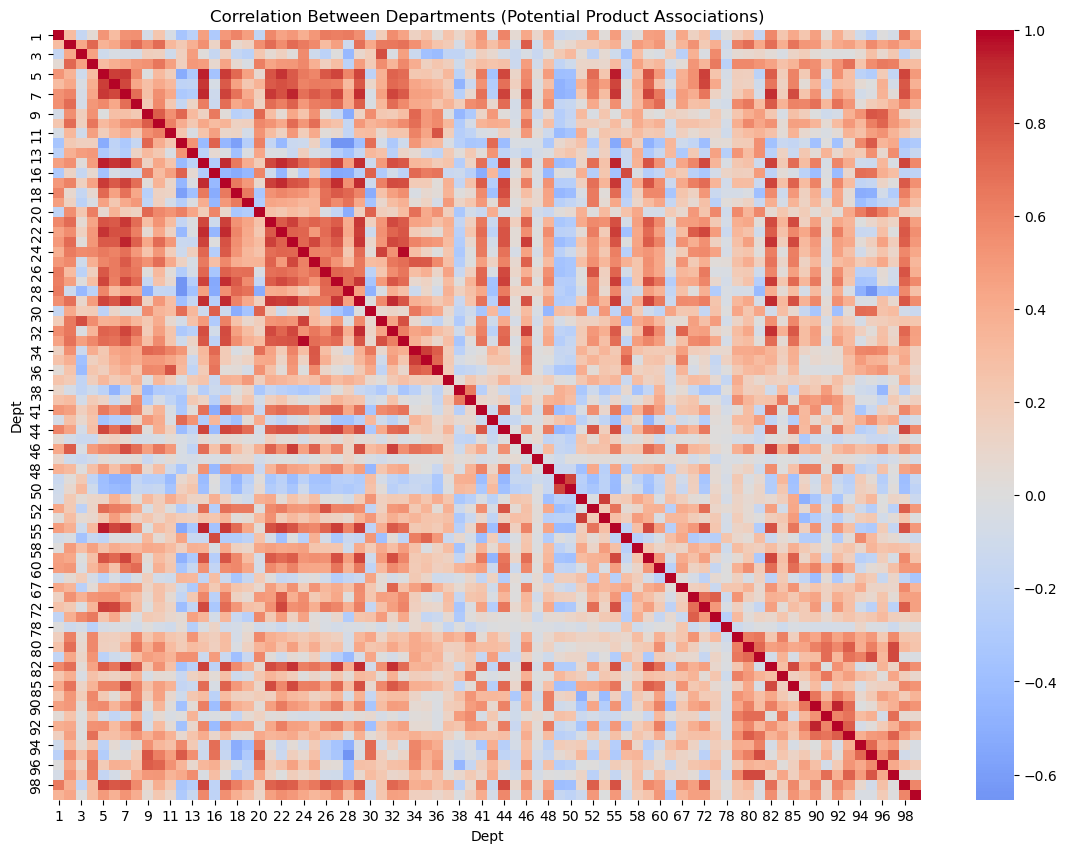

      Dept1  Dept2  Correlation
1747     24     33     0.982348
362       5     55     0.951920
325       5     14     0.942422
489       7     23     0.938810
1064     14     55     0.938683
5374     90     92     0.938463
481       7     14     0.934044
2136     29     32     0.928711
2170     29     82     0.924173
1197     17     29     0.922639
1034     14     22     0.920378
1190     17     22     0.920298
1029     14     17     0.920285
1041     14     29     0.914632
495       7     29     0.912443
1195     17     27     0.911454
532       7     82     0.909897
2404     32     82     0.907918
332       5     22     0.901093
1702     23     82     0.898274


In [17]:
# Step 1: Aggregate sales at Dept level (across stores or within stores separately)
dept_sales = df3.groupby(['Date', 'Dept'])['Weekly_Sales'].sum().reset_index()

# Step 2: Pivot to Dept x Date matrix
dept_matrix = dept_sales.pivot(index='Date', columns='Dept', values='Weekly_Sales').fillna(0)

# Step 3: Compute correlation between departments
dept_corr = dept_matrix.corr()

# Step 4: Visualize correlation heatmap
plt.figure(figsize=(14,10))
sns.heatmap(dept_corr, cmap="coolwarm", center=0, annot=False)
plt.title("Correlation Between Departments (Potential Product Associations)")
plt.show()

# Step 5: Find top associations (fix for duplicate column names)
dept_corr.index.name = 'Dept1'
dept_corr.columns.name = 'Dept2'

corr_pairs = dept_corr.unstack().reset_index()
corr_pairs.columns = ['Dept1', 'Dept2', 'Correlation']

# Remove self-correlations
corr_pairs = corr_pairs[corr_pairs['Dept1'] != corr_pairs['Dept2']]

# Drop duplicate pairs (keep only one of (A,B) and (B,A))
corr_pairs = corr_pairs.drop_duplicates(subset=['Correlation'])

# Sort by strongest associations
strong_associations = corr_pairs.sort_values(by="Correlation", ascending=False).head(20)
print(strong_associations)

#### Model to forecast weekly sales

In [22]:


df4 = df2.copy()

# --- Feature engineering ---
df4 = df4.sort_values(['Store','Dept','Date']).copy()
df4['Week'] = df4['Date'].dt.isocalendar().week.astype(int)
lags = [1,2,3,4,12]
for lag in lags:
    df4[f'lag_{lag}'] = df4.groupby(['Store','Dept'])['Weekly_Sales'].shift(lag)
df4 = df4.dropna(subset=['lag_1']).reset_index(drop=True)

# fill numeric NaNs
num_cols = df4.select_dtypes(include=[np.number]).columns.tolist()
num_cols = [c for c in num_cols if c != 'Weekly_Sales']
df4[num_cols] = df4[num_cols].fillna(0)

# encode cat
df4['IsHoliday'] = df4['IsHoliday'].astype('int')
df4['Store_code'] = df4['Store'].astype('category').cat.codes
df4['Dept_code'] = df4['Dept'].astype('category').cat.codes

# train/test split (time-based)
df4 = df4.sort_values('Date').reset_index(drop=True)
unique_dates = np.sort(df['Date'].unique())
test_weeks = 52 if len(unique_dates) >= 52 else max(1, int(len(unique_dates)*0.2))
cutoff = unique_dates[-test_weeks]
train = df4[df4['Date'] < cutoff].copy()
test = df4[df4['Date'] >= cutoff].copy()

# features
feature_cols = ['Store_code','Dept_code','Year','Month','Week'] + [f'lag_{l}' for l in lags]
X_train, y_train = train[feature_cols], train['Weekly_Sales']
X_test, y_test = test[feature_cols], test['Weekly_Sales']

# Model
if LGB:
    lgb_train = lgb.Dataset(X_train, label=y_train)
    lgb_valid = lgb.Dataset(X_test, label=y_test, reference=lgb_train)
    params = {'objective':'regression','metric':'rmse','learning_rate':0.05,'num_leaves':64}
    model = lgb.train(
    params,
    lgb_train,
    valid_sets=[lgb_train, lgb_valid],
    num_boost_round=200  # fixed number of rounds
)

    preds = model.predict(X_test, num_iteration=model.best_iteration)
else:
    rf = RandomForestRegressor(n_estimators=200, n_jobs=-1, random_state=42)
    rf.fit(X_train, y_train)
    model = rf
    preds = model.predict(X_test)

rmse = mean_squared_error(y_test, preds)
mape = mean_absolute_percentage_error(y_test.clip(1), preds.clip(1))
print(f"Test RMSE: {rmse:.2f}, MAPE: {mape:.4f}")

# Save outputs
test_out = test[['Store','Dept','Date','Weekly_Sales']].copy()
test_out['pred'] = preds
test_out.to_csv("test_predictions_sample.csv", index=False)
print("Saved test predictions -> test_predictions_sample.csv")

# Iterative 12-week forecast example (simple lag-propagation)
history = df4.groupby(['Store_code','Dept_code']).tail(52)
if history.empty:
    history = df4.groupby(['Store_code','Dept_code']).tail(1)
forecasts = []
for h in range(12):
    next_date = history['Date'].max() + pd.Timedelta(weeks=1)
    last = history.groupby(['Store_code','Dept_code']).tail(1).reset_index(drop=True)
    row = last.copy(); row['Date'] = next_date
    # update lags
    for i, lag in enumerate(sorted(lags)):
        if i == 0:
            row[f'lag_{lag}'] = history.groupby(['Store_code','Dept_code'])['Weekly_Sales'].tail(1).values
        else:
            row[f'lag_{lag}'] = history.groupby(['Store_code','Dept_code'])[f'lag_{sorted(lags)[i-1]}'].tail(1).values
    X_next = row[feature_cols]
    pred = model.predict(X_next)
    row['pred'] = pred
    forecasts.append(row[['Store','Dept','Date','pred']])
    add = row.copy(); add['Weekly_Sales'] = add['pred']
    history = pd.concat([history, add], ignore_index=True, sort=False)

pd.concat(forecasts).to_csv("12week_forecasts.csv", index=False)
print("Saved 12-week forecasts -> 12week_forecasts.csv")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018325 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1467
[LightGBM] [Info] Number of data points in the train set: 263930, number of used features: 10
[LightGBM] [Info] Start training from score 15871.903003
Test RMSE: 16277317.60, MAPE: 1.7384
Saved test predictions -> test_predictions_sample.csv
Saved 12-week forecasts -> 12week_forecasts.csv
